In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import betareg

import importlib

In [2]:
importlib.reload(betareg)

<module 'betareg' from 'c:\\Users\\yuhha\\OneDrive\\桌面\\LogisticProject-main\\LogisticProject-main\\betareg.py'>

In [3]:
nominal_df = pd.read_csv("nominal_expenditures.csv")
normalized_df = pd.read_csv("normalized_food_expenditures.csv")
constant_df = pd.read_csv("constant_dollar_expenditures.csv")
monthly_df=pd.read_csv("monthly_sales.csv")

cpi_past_df = pd.read_csv("historicalcpi.csv")
cpi_new_df = pd.read_csv("CPIForecast.csv")
# nominal_expenditures_no_taxes_tips = pd.read_csv("nominal_expenditures_no_taxes_tips.csv")
# constant_dollar_expenditures_no_taxes_tips =pd.read_csv("constant_dollar_expenditures_no_taxes_tips.csv")
# food_expenditures_source_funds=pd.read_csv("food_expenditures_source_funds.csv")
# monthly_sales_by_outlet=pd.read_csv("monthly_sales by outlet.csv")

monthly_df = monthly_df[monthly_df['Year'] < 2024]
wage_info = pd.read_csv("LES1252881600Q.csv")
wage_info["Median usual weekly real earnings"] = wage_info["LES1252881600Q"]
wage_info = wage_info.drop(["LES1252881600Q"], axis=1)

In [4]:
cpi_past_df = cpi_past_df[
    (cpi_past_df['Year'] >= 1997) & (cpi_past_df['Year'] <= 2021) &
    (cpi_past_df['Consumer Price Index item'].isin(['All food', 'Food at home', 'Food away from home']))
]

# Filter for annual data (2022–2023)
cpi_new_df = cpi_new_df[
    (cpi_new_df['Attribute'].isin(['Annual 2022', 'Annual 2023'])) &
    (cpi_new_df['Top-level'] == 'All food') &
    (cpi_new_df['Aggregate'].isin(['', 'Food at home', 'Food away from home']) | cpi_new_df['Aggregate'].isna())
]

# Map columns
cpi_new_df = cpi_new_df.rename(columns={'Value': 'Percent change'})
cpi_new_df['Year'] = cpi_new_df['Attribute'].str.extract(r'(\d{4})').astype(int)
cpi_new_df['Consumer Price Index item'] = cpi_new_df['Top-level']
cpi_new_df.loc[cpi_new_df['Aggregate'].notna() & (cpi_new_df['Aggregate'] != ''), 'Consumer Price Index item'] = cpi_new_df['Aggregate']
cpi_new_df = cpi_new_df[['Consumer Price Index item', 'Year', 'Percent change']]

# Merge CPI
cpi_df = pd.concat([cpi_past_df, cpi_new_df], ignore_index=True)
cpi_df = cpi_df.drop_duplicates(subset=['Year', 'Consumer Price Index item'], keep='first')

cpi_df = cpi_df.pivot(index='Year', columns='Consumer Price Index item', values='Percent change').reset_index()
cpi_df.columns = ['Year', 'CPI_All_food', 'CPI_Food_at_home', 'CPI_Food_away_from_home']


# print(cpi_df.tail())

In [5]:
merged_df = nominal_df.merge(normalized_df, on='Year', how='inner')
merged_df = merged_df.merge(constant_df, on='Year', how='inner', suffixes=('_nominal', '_constant'))
merged_df = merged_df.merge(cpi_df, on='Year', how='inner')
merged_df["Median usual weekly real earnings"] = wage_info["Median usual weekly real earnings"]

print(merged_df.shape)

(27, 78)


In [6]:
numerical_cols = [col for col in merged_df.columns if col != 'Year']
for col in numerical_cols:
    if merged_df[col].dtype == 'object':  
        merged_df[col] = pd.to_numeric(merged_df[col].str.replace(',', ''), errors='coerce')

numerical_cols_monthly = [col for col in monthly_df.columns if col not in ['Year', 'Month']]
for col in numerical_cols_monthly:
    if monthly_df[col].dtype == 'object':
        monthly_df[col] = pd.to_numeric(monthly_df[col].str.replace(',', ''), errors='coerce')

print(merged_df[numerical_cols].dtypes)
print(merged_df[numerical_cols].isna().sum())

print("\nData types in monthly_df after conversion:")
print(monthly_df.dtypes)
print(monthly_df.isna().sum())

Grocery stores sales million nominal U.S. dollars with taxes and tips                           float64
Convenience stores sales million nominal U.S. dollars with taxes and tips                       float64
Other food stores sales million nominal U.S. dollars with taxes and tips                        float64
Warehouse clubs and supercenters sales million nominal U.S. dollars with taxes and tips         float64
Other stores and foodservice sales million nominal U.S. dollars with taxes and tips             float64
                                                                                                 ...   
Total alcohol away from home sales million constant 1988 U.S. dollars without taxes and tips    float64
CPI_All_food                                                                                    float64
CPI_Food_at_home                                                                                float64
CPI_Food_away_from_home                                         

In [7]:
monthly_df.columns

Index(['Year', 'Month',
       'Food at home sales million nominal U.S. dollars with taxes and tips',
       'Food away from home sales million nominal U.S. dollars with taxes and tips',
       'Total food sales million nominal U.S. dollars with taxes and tips',
       'Food at home sales million constant 1988 U.S. dollars with taxes and tips',
       'Food away from home sales million constant 1988 U.S. dollars with taxes and tips',
       'Total food sales million constant 1988 U.S. dollars with taxes and tips'],
      dtype='object')

In [8]:
monthly_annual_df = monthly_df.groupby('Year')[numerical_cols_monthly].sum().reset_index()

print(monthly_annual_df.shape)


(27, 7)


## Rename column name (too long)

In [9]:
rename_dict = {
    'Grocery stores sales million nominal U.S. dollars with taxes and tips': 'Grocery_Sales_Nominal',
    'Convenience stores sales million nominal U.S. dollars with taxes and tips': 'Convenience_Sales_Nominal',
    'Other food stores sales million nominal U.S. dollars with taxes and tips': 'Other_Food_Stores_Sales_Nominal',
    'Warehouse clubs and supercenters sales million nominal U.S. dollars with taxes and tips': 'Warehouse_Sales_Nominal',
    'Other stores and foodservice sales million nominal U.S. dollars with taxes and tips': 'Other_Stores_Sales_Nominal',
    'Mail order and home delivery sales million nominal U.S. dollars with taxes and tips': 'Mail_Order_Sales_Nominal',
    'Direct selling by farmers, manufacturers, and wholesalers sales million nominal U.S. dollars with taxes and tips': 'Direct_Selling_Sales_Nominal',
    'Home production and donations sales million nominal U.S. dollars with taxes and tips': 'Home_Production_Sales_Nominal',
    'Total food at home sales million nominal U.S. dollars with taxes and tips': 'Total_Food_At_Home_Sales_Nominal',
    'Full-service restaurants sales million nominal U.S. dollars with taxes and tips': 'Full_Service_Restaurants_Sales_Nominal',
    'Limited-service restaurants sales million nominal U.S. dollars with taxes and tips': 'Limited_Service_Restaurants_Sales_Nominal',
    'Drinking places sales million nominal U.S. dollars with taxes and tips': 'Drinking_Places_Sales_Nominal',
    'Hotels and motels sales million nominal U.S. dollars with taxes and tips': 'Hotels_Motels_Sales_Nominal',
    'Retail stores and vending sales million nominal U.S. dollars with taxes and tips': 'Retail_Vending_Sales_Nominal',
    'Recreational places sales million nominal U.S. dollars with taxes and tips': 'Recreational_Places_Sales_Nominal',
    'Schools and colleges sales million nominal U.S. dollars with taxes and tips': 'Schools_Colleges_Sales_Nominal',
    'Other food away from home sales, not elsewhere classified, million nominal U.S. dollars with taxes and tips': 'Other_Food_Away_Sales_Nominal',
    'Food away from home, food furnished and donated sales million nominal U.S. dollars with taxes and tips': 'Food_Furnished_Donated_Sales_Nominal',
    'Total food away from home sales million nominal U.S. dollars with taxes and tips': 'Total_Food_Away_Sales_Nominal',
    'Liquor stores sales million nominal U.S. dollars with taxes and tips': 'Liquor_Stores_Sales_Nominal',
    'Food stores alcohol sales million nominal U.S. dollars with taxes and tips': 'Food_Stores_Alcohol_Sales_Nominal',
    'Other alcohol at home sales, not elsewhere classified, million dollars U.S. nominal dollars with taxes and tips': 'Other_Alcohol_At_Home_Sales_Nominal',
    'Total alcohol at home sales million dollars nominal U.S. dollars with taxes and tips': 'Total_Alcohol_At_Home_Sales_Nominal',
    'Eating and drinking places alcohol sales million dollars nominal U.S. dollars with taxes and tips': 'Eating_Drinking_Alcohol_Sales_Nominal',
    'Hotels and motels alcohol sales million nominal U.S. dollars with taxes and tips': 'Hotels_Motels_Alcohol_Sales_Nominal',
    'Other alcohol away from home, not elsewhere classified, sales million nominal U.S. dollars with taxes and tips': 'Other_Alcohol_Away_Sales_Nominal',
    'Total alcohol away from home sales million nominal U.S. dollars with taxes and tips': 'Total_Alcohol_Away_Sales_Nominal',
    'Food at home expenditures percentage share of disposable personal income per household nominal U.S. dollars': 'Food_At_Home_DPI_Share',
    'Food away from home expenditures percentage share of disposable personal income per household nominal U.S. dollars': 'Food_Away_DPI_Share',
    'Total food expenditures percentage share of disposable personal income per household nominal U.S. dollars': 'Total_Food_DPI_Share',
    'Food at home percentage share of food expenditures nominal U.S. dollars': 'Food_At_Home_Proportion',
    'Food away from home percentage share of food expenditures nominal U.S. dollars': 'Food_Away_Proportion',
    'Food at home expenditures per household nominal U.S. dollars': 'Food_At_Home_Per_Household_Nominal',
    'Food away from home expenditures per household nominal U.S. dollars': 'Food_Away_Per_Household_Nominal',
    'Total food expenditures per household nominal U.S. dollars': 'Total_Food_Per_Household_Nominal',
    'Food at home expenditures per household constant 1988 U.S. dollars': 'Food_At_Home_Per_Household_Constant',
    'Food away from home expenditures per household constant 1988 U.S. dollars': 'Food_Away_Per_Household_Constant',
    'Total food expenditures per household constant 1988 U.S. dollars': 'Total_Food_Per_Household_Constant',
    'Food at home percentage share of food expenditures nominal U.S. dollars for all purchasers': 'Food_At_Home_Proportion_All_Purchasers',
    'Food away from home percentage share of food expenditures nominal U.S. dollars for all purchasers': 'Food_Away_Proportion_All_Purchasers',
    'Food at home expenditures per capita nominal U.S. dollars for all purchasers': 'Food_At_Home_Per_Capita_Nominal',
    'Food away from home expenditures per capita nominal U.S. dollars for all purchasers': 'Food_Away_Per_Capita_Nominal',
    'Total food expenditures per capita nominal U.S. dollars for all purchasers': 'Total_Food_Per_Capita_Nominal',
    'Food at home expenditures per capita for all purchasers in constant 1988 U.S. dollars': 'Food_At_Home_Per_Capita_Constant',
    'Food away from home expenditures per capita for all purchasers in constant 1988 U.S. dollars': 'Food_Away_Per_Capita_Constant',
    'Total food expenditures per capita for all purchasers in constant 1988 U.S. dollars': 'Total_Food_Per_Capita_Constant',
    'Grocery stores sales million constant 1988 U.S. dollars with taxes and tips': 'Grocery_Sales_Constant',
    'Convenience stores sales million constant 1988 U.S. dollars with taxes and tips': 'Convenience_Sales_Constant',
    'Other food stores sales million constant 1988 U.S. dollars with taxes and tips': 'Other_Food_Stores_Sales_Constant',
    'Warehouse clubs and supercenters sales million constant 1988 U.S. dollars with taxes and tips': 'Warehouse_Sales_Constant',
    'Other stores and foodservice sales million constant 1988 U.S. dollars with taxes and tips': 'Other_Stores_Sales_Constant',
    'Mail order and home delivery sales million constant 1988 U.S. dollars with taxes and tips': 'Mail_Order_Sales_Constant',
    'Direct selling by farmers, manufacturers, and wholesalers sales million constant 1988 U.S. dollars with taxes and tips': 'Direct_Selling_Sales_Constant',
    'Home production and donations sales million constant 1988 U.S. dollars with taxes and tips': 'Home_Production_Sales_Constant',
    'Total food at home sales million constant 1988 U.S. dollars with taxes and tips': 'Total_Food_At_Home_Sales_Constant',
    'Full-service restaurants sales million constant 1988 U.S. dollars with taxes and tips': 'Full_Service_Restaurants_Sales_Constant',
    'Limited-service restaurants sales million constant 1988 U.S. dollars with taxes and tips': 'Limited_Service_Restaurants_Sales_Constant',
    'Drinking places sales million constant 1988 U.S. dollars without taxes and tips': 'Drinking_Places_Sales_Constant',
    'Hotels and motels sales million constant 1988 U.S. dollars without taxes and tips': 'Hotels_Motels_Sales_Constant',
    'Retail stores and vending sales million constant 1988 U.S. dollars without taxes and tips': 'Retail_Vending_Sales_Constant',
    'Recreational places sales million constant 1988 U.S. dollars without taxes and tips': 'Recreational_Places_Sales_Constant',
    'Schools and colleges sales million constant 1988 U.S. dollars without taxes and tips': 'Schools_Colleges_Sales_Constant',
    'Other food away from home sales, not elsewhere classified, million constant 1988 U.S. dollars without taxes and tips': 'Other_Food_Away_Sales_Constant',
    'Food furnished and donated sales million constant 1988 U.S. dollars without taxes and tips': 'Food_Furnished_Donated_Sales_Constant',
    'Total food away from home sales million constant 1988 U.S. dollars without taxes and tips': 'Total_Food_Away_Sales_Constant',
    'Liquor stores sales million constant 1988 U.S. dollars without taxes and tips': 'Liquor_Stores_Sales_Constant',
    'Food stores alcohol sales million constant 1988 U.S. dollars without taxes and tips': 'Food_Stores_Alcohol_Sales_Constant',
    'Other alcohol at home sales, not elsewhere classified, million constant 1988 U.S. dollars without taxes and tips': 'Other_Alcohol_At_Home_Sales_Constant',
    'Total alcohol at home sales million constant 1988 U.S. dollars without taxes and tips': 'Total_Alcohol_At_Home_Sales_Constant',
    'Eating and drinking places alcohol sales million constant 1988 U.S. dollars without taxes and tips': 'Eating_Drinking_Alcohol_Sales_Constant',
    'Hotels and motels alcohol sales million constant 1988 U.S. dollars without taxes and tips': 'Hotels_Motels_Alcohol_Sales_Constant',
    'Other alcohol away from home, not elsewhere classified, sales million constant 1988 U.S. dollars without taxes and tips': 'Other_Alcohol_Away_Sales_Constant',
    'Total alcohol away from home sales million constant 1988 U.S. dollars without taxes and tips': 'Total_Alcohol_Away_Sales_Constant'
}

merged_df = merged_df.rename(columns=rename_dict)

In [10]:
merged_df.columns

Index(['Year', 'Grocery_Sales_Nominal', 'Convenience_Sales_Nominal',
       'Other_Food_Stores_Sales_Nominal', 'Warehouse_Sales_Nominal',
       'Other_Stores_Sales_Nominal', 'Mail_Order_Sales_Nominal',
       'Direct_Selling_Sales_Nominal', 'Home_Production_Sales_Nominal',
       'Total_Food_At_Home_Sales_Nominal',
       'Full_Service_Restaurants_Sales_Nominal',
       'Limited_Service_Restaurants_Sales_Nominal',
       'Drinking_Places_Sales_Nominal', 'Hotels_Motels_Sales_Nominal',
       'Retail_Vending_Sales_Nominal', 'Recreational_Places_Sales_Nominal',
       'Schools_Colleges_Sales_Nominal', 'Other_Food_Away_Sales_Nominal',
       'Food_Furnished_Donated_Sales_Nominal', 'Total_Food_Away_Sales_Nominal',
       'Liquor_Stores_Sales_Nominal', 'Food_Stores_Alcohol_Sales_Nominal',
       'Other_Alcohol_At_Home_Sales_Nominal',
       'Total_Alcohol_At_Home_Sales_Nominal',
       'Eating_Drinking_Alcohol_Sales_Nominal',
       'Hotels_Motels_Alcohol_Sales_Nominal',
       'Other_Alcoh

# EDA

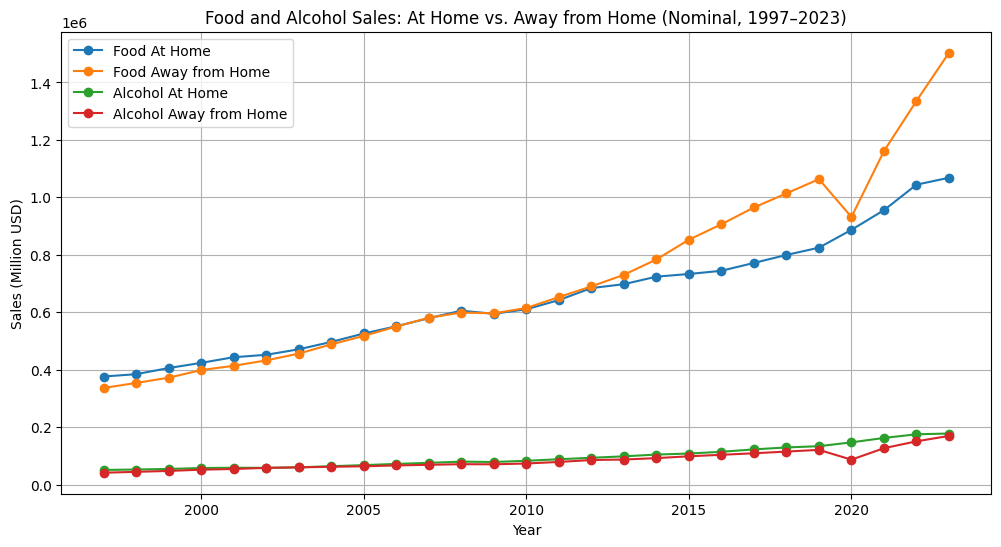

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Total_Food_At_Home_Sales_Nominal'], marker='o', label='Food At Home')
plt.plot(merged_df['Year'], merged_df['Total_Food_Away_Sales_Nominal'], marker='o', label='Food Away from Home')
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_At_Home_Sales_Nominal'], marker='o', label='Alcohol At Home')
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_Away_Sales_Nominal'], marker='o', label='Alcohol Away from Home')
plt.title('Food and Alcohol Sales: At Home vs. Away from Home (Nominal, 1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

- Food away from home sales grew significantly, especially post-2020, while food at home sales increased more steadily. 
- Alcohol sales (both at home and away) remained relatively flat, with a slight uptick in 2020, likely due to pandemic shifts.

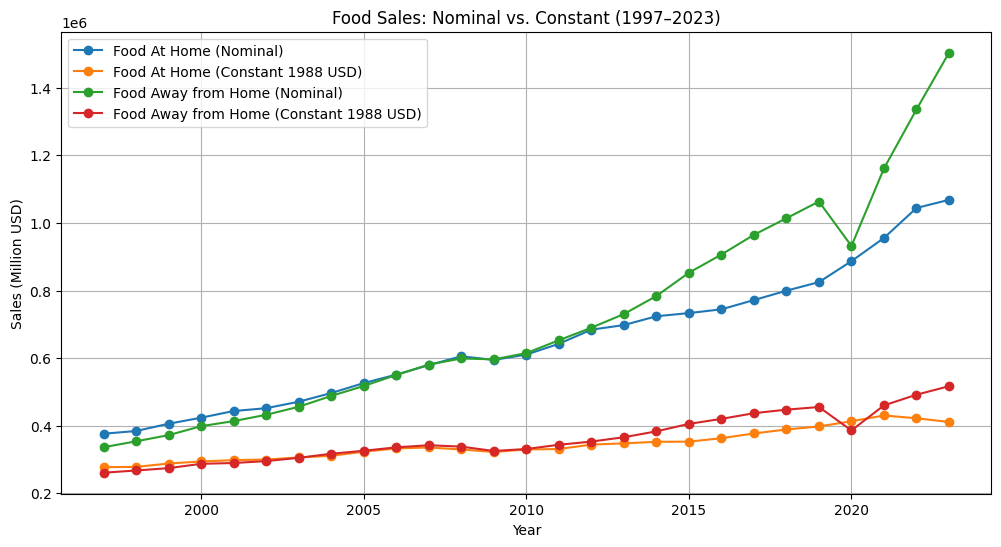

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Total_Food_At_Home_Sales_Nominal'], marker='o', label='Food At Home (Nominal)')
plt.plot(merged_df['Year'], merged_df['Total_Food_At_Home_Sales_Constant'], marker='o', label='Food At Home (Constant 1988 USD)')
plt.plot(merged_df['Year'], merged_df['Total_Food_Away_Sales_Nominal'], marker='o', label='Food Away from Home (Nominal)')
plt.plot(merged_df['Year'], merged_df['Total_Food_Away_Sales_Constant'], marker='o', label='Food Away from Home (Constant 1988 USD)')
plt.title('Food Sales: Nominal vs. Constant (1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

- Nominal food sales (at home and away) rose sharply, reflecting inflation. 
- Constant sales (1988 USD) grew more slowly, showing real spending increases were modest. 
- Dip in away home 2020 = pandemic impacts.

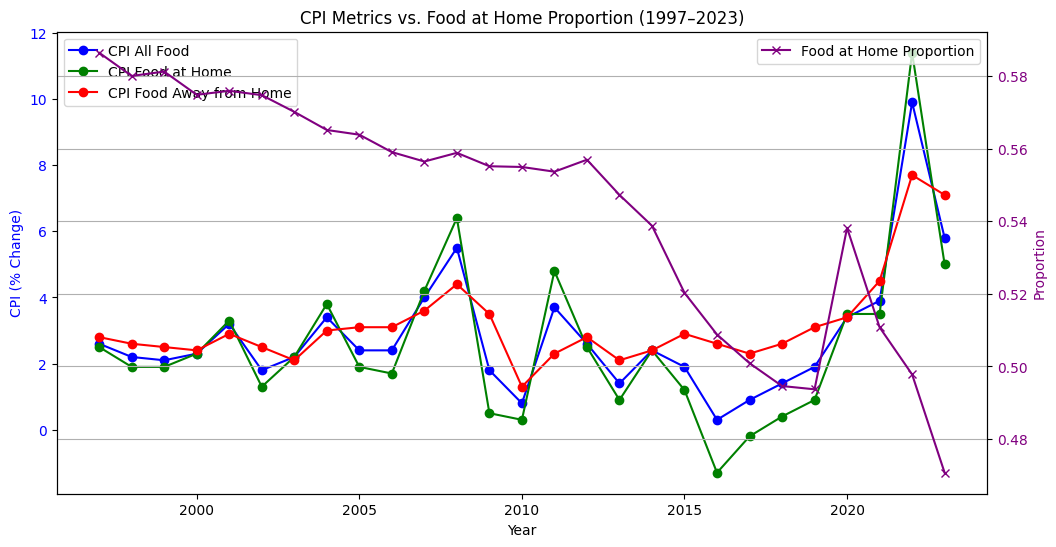

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# CPI on the left
ax1.plot(merged_df['Year'], merged_df['CPI_All_food'], marker='o', label='CPI All Food', color='blue')
ax1.plot(merged_df['Year'], merged_df['CPI_Food_at_home'], marker='o', label='CPI Food at Home', color='green')
ax1.plot(merged_df['Year'], merged_df['CPI_Food_away_from_home'], marker='o', label='CPI Food Away from Home', color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('CPI (% Change)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(merged_df['Year'], merged_df['Food_At_Home_Proportion'] / 100, marker='x', label='Food at Home Proportion', color='purple')
ax2.set_ylabel('Proportion', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

plt.title('CPI Metrics vs. Food at Home Proportion (1997–2023)')
plt.grid(True)
plt.show()

- The food at home proportion declined overall.
- CPI metrics fluctuated, with peaks in 2022 (CPI Food at Home at 11.4%). 
- No clear correlation exists between CPI and proportion.

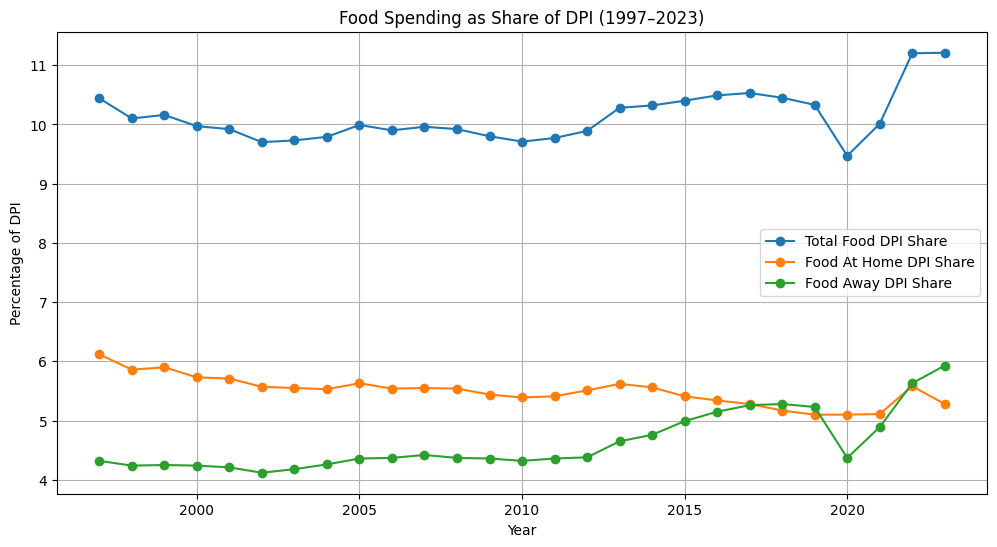

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Total_Food_DPI_Share'], marker='o', label='Total Food DPI Share')
plt.plot(merged_df['Year'], merged_df['Food_At_Home_DPI_Share'], marker='o', label='Food At Home DPI Share')
plt.plot(merged_df['Year'], merged_df['Food_Away_DPI_Share'], marker='o', label='Food Away DPI Share')
plt.title('Food Spending as Share of DPI (1997–2023)')
plt.xlabel('Year')
plt.ylabel('Percentage of DPI')
plt.legend()
plt.grid(True)
plt.show()

- The decline in DPI share despite rising nominal sales above suggests income growth outpaces food spending, except in 2020–2023.
- Inflation also plays a role in the 2023 increase.

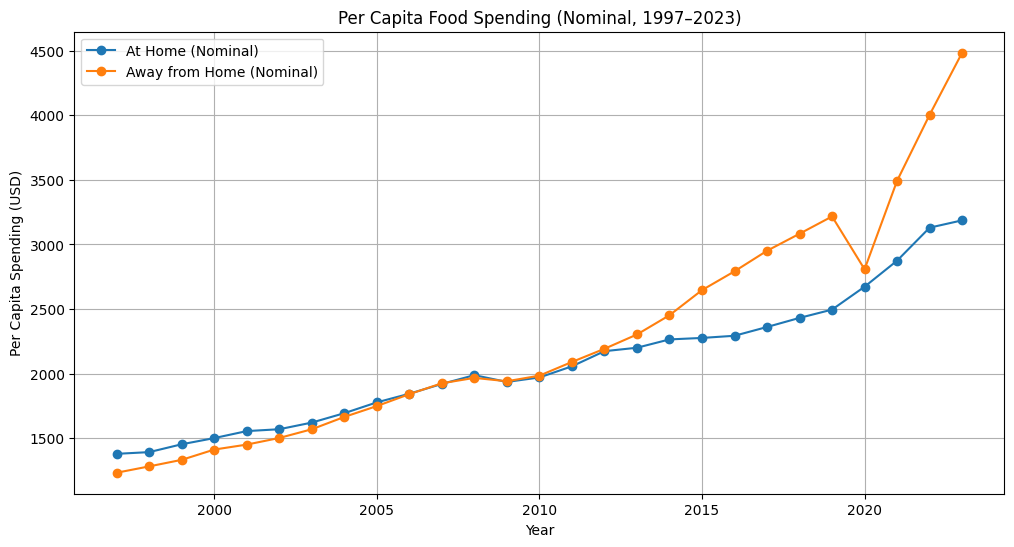

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Food_At_Home_Per_Capita_Nominal'], marker='o', label='At Home (Nominal)')
plt.plot(merged_df['Year'], merged_df['Food_Away_Per_Capita_Nominal'], marker='o', label='Away from Home (Nominal)')
plt.title('Per Capita Food Spending (Nominal, 1997–2023)')
plt.xlabel('Year')
plt.ylabel('Per Capita Spending (USD)')
plt.legend()
plt.grid(True)
plt.show()

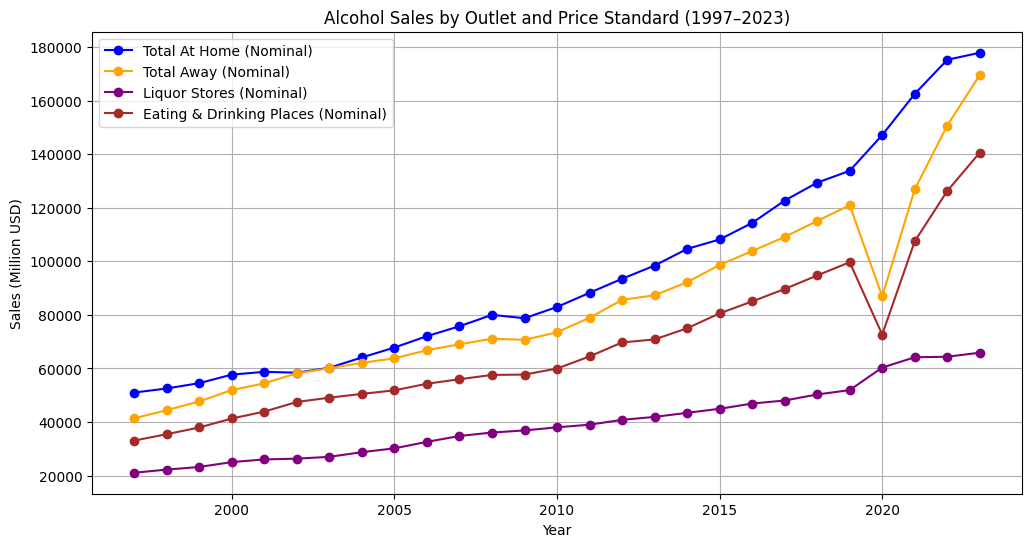

In [16]:
plt.figure(figsize=(12, 6))
# Total Alcohol Sales
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_At_Home_Sales_Nominal'], marker='o', label='Total At Home (Nominal)', color='blue')
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_Away_Sales_Nominal'], marker='o', label='Total Away (Nominal)', color='orange')
# plt.plot(merged_df['Year'], merged_df['Total_Alcohol_At_Home_Sales_Constant'], marker='o', label='Total At Home (Constant 1988 USD)', color='green')
# plt.plot(merged_df['Year'], merged_df['Total_Alcohol_Away_Sales_Constant'], marker='o', label='Total Away (Constant 1988 USD)', color='red')
# Key Outlets (Nominal)
plt.plot(merged_df['Year'], merged_df['Liquor_Stores_Sales_Nominal'], marker='o', label='Liquor Stores (Nominal)', color='purple')
plt.plot(merged_df['Year'], merged_df['Eating_Drinking_Alcohol_Sales_Nominal'], marker='o', label='Eating & Drinking Places (Nominal)', color='brown')
plt.title('Alcohol Sales by Outlet and Price Standard (1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

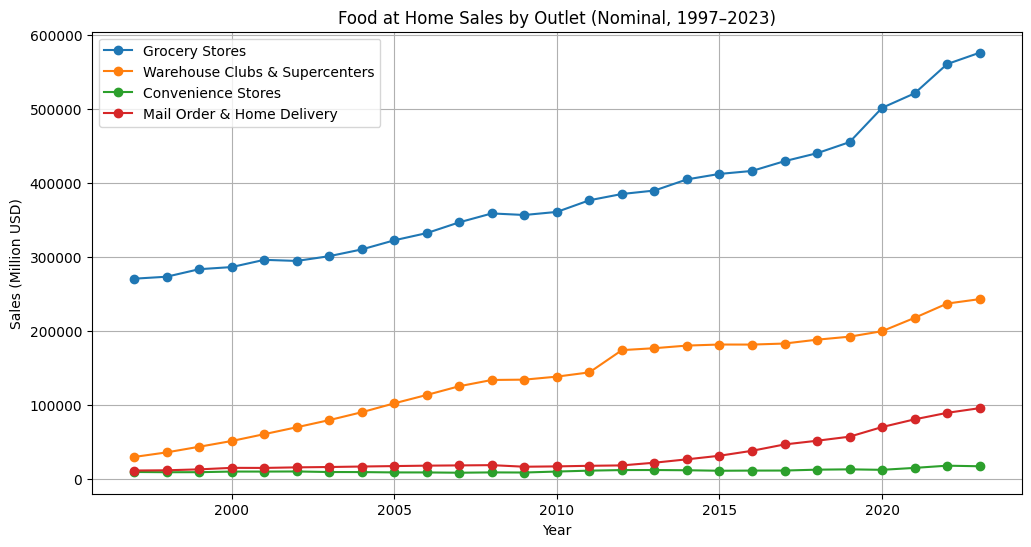

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Grocery_Sales_Nominal'], marker='o', label='Grocery Stores')
plt.plot(merged_df['Year'], merged_df['Warehouse_Sales_Nominal'], marker='o', label='Warehouse Clubs & Supercenters')
plt.plot(merged_df['Year'], merged_df['Convenience_Sales_Nominal'], marker='o', label='Convenience Stores')
plt.plot(merged_df['Year'], merged_df['Mail_Order_Sales_Nominal'], marker='o', label='Mail Order & Home Delivery')
plt.title('Food at Home Sales by Outlet (Nominal, 1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
merged_df.keys()

Index(['Year', 'Grocery_Sales_Nominal', 'Convenience_Sales_Nominal',
       'Other_Food_Stores_Sales_Nominal', 'Warehouse_Sales_Nominal',
       'Other_Stores_Sales_Nominal', 'Mail_Order_Sales_Nominal',
       'Direct_Selling_Sales_Nominal', 'Home_Production_Sales_Nominal',
       'Total_Food_At_Home_Sales_Nominal',
       'Full_Service_Restaurants_Sales_Nominal',
       'Limited_Service_Restaurants_Sales_Nominal',
       'Drinking_Places_Sales_Nominal', 'Hotels_Motels_Sales_Nominal',
       'Retail_Vending_Sales_Nominal', 'Recreational_Places_Sales_Nominal',
       'Schools_Colleges_Sales_Nominal', 'Other_Food_Away_Sales_Nominal',
       'Food_Furnished_Donated_Sales_Nominal', 'Total_Food_Away_Sales_Nominal',
       'Liquor_Stores_Sales_Nominal', 'Food_Stores_Alcohol_Sales_Nominal',
       'Other_Alcohol_At_Home_Sales_Nominal',
       'Total_Alcohol_At_Home_Sales_Nominal',
       'Eating_Drinking_Alcohol_Sales_Nominal',
       'Hotels_Motels_Alcohol_Sales_Nominal',
       'Other_Alcoh

# Relativaty

In [19]:
m2 = pd.read_excel("API_NY.GDP.PCAP.PP.CD_DS2_en_excel_v2_19540.xls")
m2_subset = m2[['Year', 'US PPP']]
merged_df2 = merged_df.merge(m2_subset, how='left', on='Year')

In [20]:
pop = pd.read_excel("hh4.xls")
pop = pop.iloc[2:]
# hs = pop.iloc[::-1].iloc[38:]["Average number of people per household"]
pop.head()

,Year,All households,Average number of people per household
2,2023,131434.0,2.51
3,2022,131202.0,2.50
4,2021,129931.0,2.54
5,2020,128451.0,2.53
6,2019,128579.0,2.52


In [21]:
pop_subset = pop[['Year', 'Average number of people per household']]

# Now, merge it into merge_df using the 'Year' column
merged_df2 = merged_df2.merge(pop_subset, how='left', on='Year')
merged_df2.head()

,Year,Grocery_Sales_Nominal,Convenience_Sales_Nominal,Other_Food_Stores_Sales_Nominal,Warehouse_Sales_Nominal,Other_Stores_Sales_Nominal,Mail_Order_Sales_Nominal,Direct_Selling_Sales_Nominal,Home_Production_Sales_Nominal,Total_Food_At_Home_Sales_Nominal,...,Eating_Drinking_Alcohol_Sales_Constant,Hotels_Motels_Alcohol_Sales_Constant,Other_Alcohol_Away_Sales_Constant,Total_Alcohol_Away_Sales_Constant,CPI_All_food,CPI_Food_at_home,CPI_Food_away_from_home,Median usual weekly real earnings,US PPP,Average number of people per household
0,1997,270956.91,9765.15,10710.83,30061.36,37863.49,11725.54,4117.00,1127.42,376327.72,...,22814.35,2891.07,2850.81,28556.23,2.6,2.5,2.8,314.0,31459.129969,2.64
1,1998,273638.88,9420.61,10807.26,36238.97,37289.61,12041.76,3807.23,1149.58,384393.91,...,23754.91,2982.04,3025.89,29762.84,2.2,1.9,2.6,322.0,32853.672595,2.62
2,1999,283782.47,9475.88,10730.30,43846.57,40038.48,13297.68,3465.68,1171.82,405808.88,...,24675.88,3217.47,3094.02,30987.37,2.1,1.9,2.5,330.0,34515.381307,2.61
3,2000,286669.78,10320.41,11267.75,51634.55,44290.80,15332.53,3149.73,1104.32,423769.88,...,26059.24,3500.38,3195.09,32754.70,2.3,2.3,2.4,334.0,36329.970260,2.62
4,2001,296436.72,10297.79,11938.87,60863.16,44672.75,15239.96,2778.31,1244.96,443472.53,...,26646.99,3222.20,3169.53,33038.72,3.2,3.3,2.9,337.0,37133.620397,2.58


Correlation with Food_At_Home_Proportion:
Food_At_Home_Proportion                   1.000000
Average number of people per household    0.856682
Food_At_Home_DPI_Share                    0.751590
Total_Food_DPI_Share                     -0.676316
Total_Food_At_Home_Sales_Nominal         -0.914232
Total_Alcohol_At_Home_Sales_Nominal      -0.918818
Year                                     -0.921735
US PPP                                   -0.937911
Total_Food_Away_Sales_Nominal            -0.959437
Total_Alcohol_Away_Sales_Nominal         -0.959797
Name: Food_At_Home_Proportion, dtype: float64


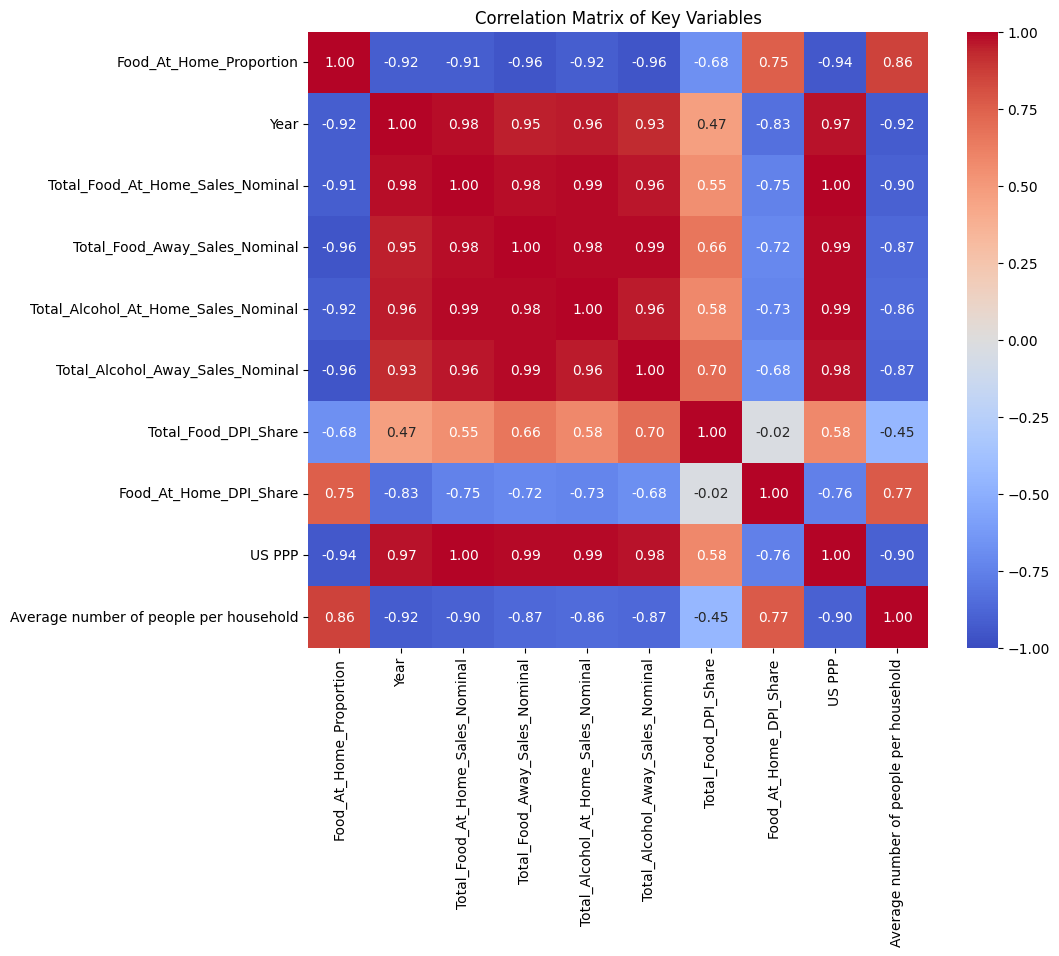

In [22]:
key_vars = [
    'Food_At_Home_Proportion',
    'Year',
    'Total_Food_At_Home_Sales_Nominal',  # Directly related to response
    'Total_Food_Away_Sales_Nominal',     # Complement to response
    'Total_Alcohol_At_Home_Sales_Nominal',
    'Total_Alcohol_Away_Sales_Nominal',
    'Total_Food_DPI_Share',              # Economic indicator
    'Food_At_Home_DPI_Share',
    'US PPP',              # Economic predictor
    'Average number of people per household',
]

corr_matrix = merged_df2[key_vars].corr()

print("Correlation with Food_At_Home_Proportion:")
print(corr_matrix['Food_At_Home_Proportion'].sort_values(ascending=False))


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Correlation Matrix of Key Variables')
plt.show()

# Statistics Tests

### Model with 2 variables

In [23]:
predictors = ["Median usual weekly real earnings"]
X = merged_df[predictors].values
predictors.append("Year")
xmean = np.mean(X,  axis=0)
xstd = np.std(X, axis=0)
X = (X - xmean) / xstd
minyear = merged_df["Year"].min()
X = np.hstack((X, (merged_df["Year"] - minyear).values.reshape(-1, 1)))

y = merged_df['Food_At_Home_Proportion'].values / 100
n = len(y)

params, X, y, I = betareg.fit_regression(X, y)

-12.031495888715575
[ 6.23407898e-02 -7.45806129e-02  5.35634523e-03  5.03024744e+01] 44.242509967375156
[ 9.90571040e-02 -1.01602492e-01  3.83955257e-03  6.89474040e+01] 48.73967904266328
[ 1.24118217e-01 -1.08331203e-01  2.31248610e-03  8.35726827e+01] 51.306454043960684
[ 1.43731803e-01 -1.06766949e-01  1.12393133e-03  9.59104131e+01] 53.10340267775814
[ 1.60373229e-01 -1.01976860e-01  1.53609442e-04  1.06777934e+02] 54.51633074161566
[ 1.75227982e-01 -9.60911710e-02 -1.02083731e-03  1.16614857e+02] 55.714078622989746
[ 1.88866495e-01 -8.99627875e-02 -1.95089256e-03  1.25689670e+02] 56.74689720661695
[ 2.01424068e-01 -8.40054263e-02 -2.72690727e-03  1.34165845e+02] 57.655415366556326
[ 2.13123685e-01 -7.83176081e-02 -3.69000140e-03  1.42159734e+02] 58.483280827198996
[ 2.24096607e-01 -7.29214453e-02 -4.47240234e-03  1.49754013e+02] 59.229074321457574
[ 2.34312715e-01 -6.78701613e-02 -5.20112608e-03  1.57006691e+02] 59.90981993222567
[ 2.43813643e-01 -6.31603312e-02 -5.82587263e-03  

In [24]:
n, p = X.shape
print(f"Condition number: {np.linalg.cond(I[:p, :p])}")
betareg.summary(params, predictors, X, y, I)

Condition number: 3004.5359047143165
Beta Regression Summary
Coefficient                         Value   Wald    P-value 
Intercept                           0.38    8.28    0.00    
Median usual weekly real earnings   0.00    0.17    0.87    
Year                                -0.02   -4.66   0.00    

Log-Likelihood:   77.23


### Year only model:

In [25]:
predictorsy = ["Year"]
Xy = merged_df[["Year"]].values
Xy = Xy - np.min(Xy)

paramsy, Xy, yy, Iy = betareg.fit_regression(Xy, y)

-12.031495888715575
[7.50422685e-02 2.51679577e-03 4.83598336e+01] 42.133441806021324
[ 1.35538329e-01 -9.99880418e-04  6.51375603e+01] 46.5925588931558
[ 1.83658799e-01 -3.98210461e-03  7.90847394e+01] 49.863001937662034
[ 2.22001804e-01 -6.13478212e-03  9.15668691e+01] 52.400446751694176
[ 2.52512922e-01 -7.97823961e-03  1.03029704e+02] 54.42860229339715
[ 2.76852002e-01 -9.32602943e-03  1.13653294e+02] 56.05616498551035
[ 2.96259691e-01 -1.05756045e-02  1.23576747e+02] 57.39728946117975
[ 3.11721740e-01 -1.12758186e-02  1.32882397e+02] 58.49128860029941
[ 3.24041428e-01 -1.22158853e-02  1.41645219e+02] 59.436081003272875
[ 3.33946778e-01 -1.28131296e-02  1.49931434e+02] 60.23489789791529
[ 3.41832590e-01 -1.32875833e-02  1.57793475e+02] 60.92824445052315
[ 3.48135280e-01 -1.35839326e-02  1.65277472e+02] 61.53675952406138
[ 3.53175745e-01 -1.39373831e-02  1.72423938e+02] 62.08285051543794
[ 3.57241860e-01 -1.41732903e-02  1.79268588e+02] 62.57398552979339
[ 3.60497555e-01 -1.43711590

In [26]:
n, p = Xy.shape
betareg.summary(paramsy, predictorsy, Xy, yy, Iy)

Beta Regression Summary
Coefficient   Value   Wald    P-value 
Intercept     0.37    13.47   0.00    
Year          -0.02   -8.31   0.00    

Log-Likelihood:   77.20


Year by itself appears significant

### Median usual weekly earnings only

In [27]:
predictorsm = ["Median usual weekly real earnings"]
Xm = merged_df[predictorsm].values
xmmean = np.mean(Xm,  axis=0)
xmstd = np.std(Xm, axis=0)
Xm = (Xm - xmmean) / xmstd

paramsm, Xm, ym, Im = betareg.fit_regression(Xm, y)

-12.031495888715575
[ 0.17389074 -0.09601702 54.07244094] 46.58584128913412
[ 0.17471801 -0.09647434 73.16371364] 50.25974600829284
[ 0.17521207 -0.09674757 87.74738052] 52.39228057515754
[ 1.75468445e-01 -9.68912426e-02  9.99096694e+01] 53.87331920568238
[ 1.75645872e-01 -9.69881866e-02  1.10499179e+02] 54.99542881235402
[ 1.75818887e-01 -9.70847889e-02  1.19961249e+02] 55.89106510498323
[ 1.75896298e-01 -9.71280552e-02  1.28564044e+02] 56.63130029939771
[ 1.75980765e-01 -9.71748184e-02  1.36483907e+02] 57.25861459924158
[ 1.76073462e-01 -9.72263503e-02  1.43844129e+02] 57.80037336355804
[ 1.76073462e-01 -9.72263503e-02  1.50734930e+02] 58.275211309702854
[ 1.76143371e-01 -9.72651780e-02  1.57224671e+02] 58.69637483557494
[ 1.76215970e-01 -9.73054924e-02  1.63366613e+02] 59.07359887305074
[ 1.76215970e-01 -9.73054924e-02  1.69203246e+02] 59.41424650296494
[ 1.76284572e-01 -9.73436214e-02  1.74769061e+02] 59.724013808825475
[ 1.76284572e-01 -9.73436214e-02  1.80092548e+02] 60.007391730

In [28]:
n, p = Xm.shape
betareg.summary(paramsm, predictorsm, Xm, ym, Im)

Beta Regression Summary
Coefficient                         Value   Wald    P-value 
Intercept                           0.18    9.25    0.00    
Median usual weekly real earnings   -0.10   -5.11   0.00    

Log-Likelihood:   65.82


It seems that median usual weekly real earnings is significant by itself by both wald and LR tests

### Null model for comparison

In [29]:
paramsn, Xn, yn, In = betareg.fit_regression(None, y)

-12.031495888715575
[ 0.17393429 51.81228864] 44.424862656043445
[ 0.17475515 68.84067833] 47.35368175846361
[ 0.17514922 81.40899537] 48.93914744276162
[ 0.1754326  91.58806686] 49.97722099109842
[  0.17556309 100.22058664] 50.723242681736906
[  0.1756631  107.74867803] 51.29035912211293
[  0.17578426 114.43842982] 51.73809606490909
[  0.17590076 120.4646548 ] 52.101366659134555
[  0.17598714 125.9494616 ] 52.40226564901104
[  0.17598714 130.9821596 ] 52.65558521550952
[  0.1760722  135.63036125] 52.87166685960369
[  0.1760722 139.946653 ] 53.05798354341914
[  0.17613403 143.97299219] 53.22010547000582
[  0.17619774 147.74335798] 53.362265996426004
[  0.17619774 151.28583909] 53.48775823144115
[  0.17619774 154.62385131] 53.59918045653649
[  0.17626574 157.77728221] 53.69862074368325
[  0.17626574 160.76306248] 53.787767019817466
[  0.17626574 163.59581564] 53.86800904038023
[  0.17632253 166.28828904] 53.94050132907819
[  0.17632253 168.85162949] 54.0062053918964
[  0.17632253 171.29

In [30]:
n, p = Xn.shape
betareg.summary(paramsn, [], Xn, yn, In)

Beta Regression Summary
Coefficient   Value   Wald    P-value 
Intercept     0.18    6.60    0.00    

Log-Likelihood:   54.67


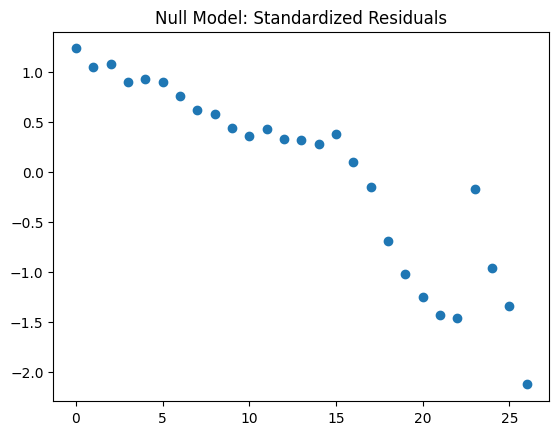

In [31]:
plt.title("Null Model: Standardized Residuals")
plt.scatter(np.arange(len(y)), betareg.std_resids(paramsn, Xn, yn))

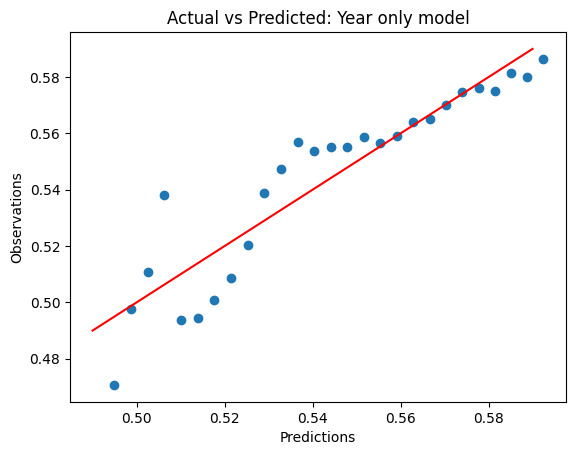

In [32]:
plt.title("Actual vs Predicted: Year only model")
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.scatter(betareg.get_mu(Xy, paramsy[:-1]), y)
plt.plot([0.49, 0.59], [0.49, 0.59], color="red")
# plt.savefig("images/yearap.png")

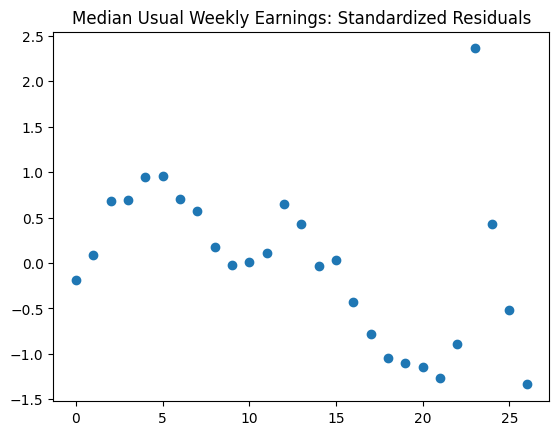

In [33]:
plt.title("Median Usual Weekly Earnings: Standardized Residuals")
plt.scatter(np.arange(len(y)), betareg.std_resids(paramsm, Xm, ym))

Text(0, 0.5, 'Residual')

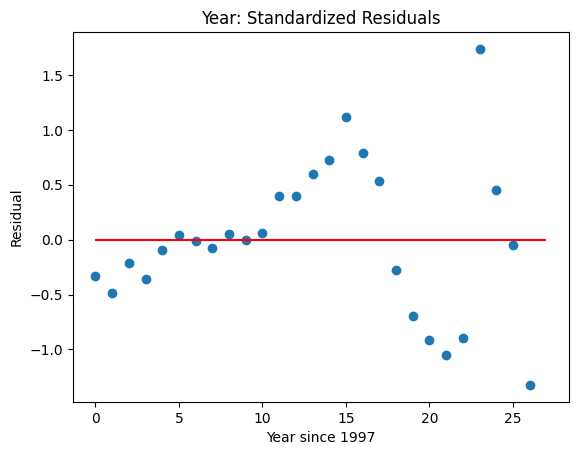

In [34]:
plt.title("Year: Standardized Residuals")
plt.scatter(np.arange(len(y)), betareg.std_resids(paramsy, Xy, yy))
plt.hlines(0, 0, 27, color="red")
plt.xlabel("Year since 1997")
plt.ylabel("Residual")
# plt.savefig("images/ystd")

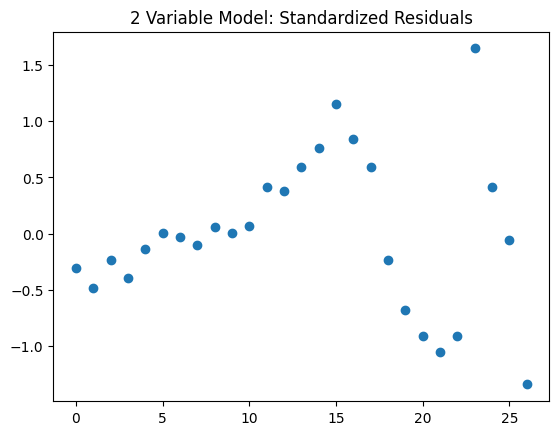

In [35]:
plt.title("2 Variable Model: Standardized Residuals")
plt.scatter(np.arange(len(y)), betareg.std_resids(params, X, y))

In [36]:
betareg.lr_test(params, paramsy, X, Xy, y)

LR Test: 1 parameter difference:
X2 Stat: 0.06007327478073421
P-Value: 0.8063801642131537


We see no significant difference between the year only model and the year/wage combined model.

It seems like there may be a significant change in the pattern around 2012, let's introduce an indicator variable for that and interact it with year

In [37]:
Xyy = np.hstack([Xy, ((merged_df["Year"] > 2012) * 1).values.reshape((-1, 1))])
Xyy = np.hstack([Xyy, (Xyy[:, -1] * Xyy[:, -2]).reshape((-1, 1))])

paramsyy, Xyy, yyy, Iyy = betareg.fit_regression(Xyy, y)

-12.031495888715575
[ 3.19861177e-02  3.19861177e-02  1.75983035e-02  1.21931052e-03
 -1.83722764e-02  5.15820807e+01] 44.6045571637149
[ 5.33988418e-02  5.33988418e-02  1.33991585e-02  2.92966391e-03
 -1.64566795e-02  6.96454449e+01] 48.66101197815772
[ 7.15194367e-02  7.15194367e-02  9.91806984e-03  4.45103270e-03
 -1.46909160e-02  8.40101674e+01] 51.415304947798404
[ 8.68179280e-02  8.68179280e-02  7.04253942e-03  5.80558396e-03
 -1.31273027e-02  9.64992066e+01] 53.53843719355393
[ 9.96985023e-02  9.96985023e-02  4.36525035e-03  7.00326574e-03
 -1.20302548e-02  1.07770422e+02] 55.29402820898122
[ 1.10553026e-01  1.10553026e-01  2.20653892e-03  8.08152185e-03
 -1.10221758e-02  1.18159681e+02] 56.741483838426575
[ 1.19728299e-01  1.19728299e-01  4.19337209e-04  9.05917992e-03
 -1.01401881e-02  1.27838879e+02] 57.96201084685481
[ 1.27505804e-01  1.27505804e-01 -1.11344611e-03  9.95203538e-03
 -9.41143789e-03  1.36936276e+02] 59.00913482550891
[ 1.34040746e-01  1.34040746e-01 -2.4042074

In [38]:
betareg.summary(paramsyy, ["Year", "Year>2012", "Year * >2012"], Xyy, yyy, Iyy)

Beta Regression Summary
Information Matrix is Singular. No test results will be printed
Coefficient    Value   
Intercept      0.17    
Year           0.17    
Year>2012      -0.01   
Year * >2012   0.09    

Log-Likelihood:   79.84


In [39]:
betareg.lr_test(paramsyy, paramsy, Xyy, Xy, y)

LR Test: 3 parameter difference:
X2 Stat: 5.283515611228722
P-Value: 0.15217562160095666


We see no significant difference between this model and the model containing only year.

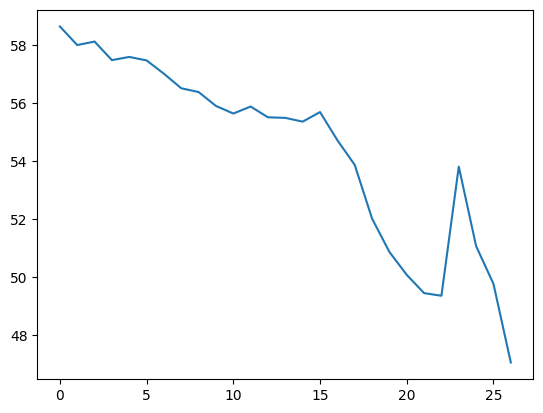

In [40]:
plt.plot(merged_df["Food_At_Home_Proportion"])

Let's see if average number of people per household may have anything to do with it.

In [41]:
hh4 = pd.read_excel("hh4.xls")
hh4 = hh4.iloc[1:]
houseSize = hh4.iloc[::-1].iloc[38:]["Average number of people per household"].values

In [42]:
Xh = np.hstack([houseSize[:-1].reshape((-1, 1))])
Xh = (Xh - np.mean(Xh, axis=0)) / np.std(Xh, axis=0)

paramsh, Xh, yh, Ih = betareg.fit_regression(Xh, y)

-12.031495888715575
[ 0.17414381  0.10852538 54.68287578] 47.1837859485895
[ 0.17497631  0.10904777 74.33925624] 51.076585340378415
[ 0.17547096  0.10936188 89.48013251] 53.37469107392144
[  0.17571593   0.10951616 102.1951011 ] 54.99317608325737
[1.75959185e-01 1.09673047e-01 1.13333818e+02] 56.23458926478247
[1.76024433e-01 1.09712725e-01 1.23342175e+02] 57.23656528220499
[1.76150559e-01 1.09793773e-01 1.32488714e+02] 58.073293974026
[1.76223543e-01 1.09840052e-01 1.40949991e+02] 58.789282709955614
[1.76282486e-01 1.09877786e-01 1.48849473e+02] 59.4133181741081
[1.76345943e-01 1.09918170e-01 1.56277521e+02] 59.96507421600745
[1.76419036e-01 1.09964689e-01 1.63302603e+02] 60.45857877474782
[1.76491657e-01 1.10011124e-01 1.69978067e+02] 60.904178185961655
[1.76491657e-01 1.10011124e-01 1.76346479e+02] 61.30972245051635
[1.76561580e-01 1.10055777e-01 1.82442399e+02] 61.681302565465785
[1.76561580e-01 1.10055777e-01 1.88294373e+02] 62.023735427787415
[1.76613155e-01 1.10088780e-01 1.9392

In [43]:
betareg.summary(paramsh, ["Avg People Per Household"], Xh, yh, Ih)

Beta Regression Summary
Coefficient                Value   Wald    P-value 
Intercept                  0.18    10.76   0.00    
Avg People Per Household   0.11    6.67    0.00    

Log-Likelihood:   71.28


Let's look at PPP

In [44]:
ppp = pd.read_excel("API_NY.GDP.PCAP.PP.CD_DS2_en_excel_v2_19540.xls").iloc[7:]["US PPP"].values

In [45]:
Xhp = np.hstack([houseSize[:-1].reshape((-1, 1)), ppp.reshape((-1, 1))])
Xhp = (Xhp - np.mean(Xhp, axis=0)) / np.std(Xhp, axis=0)

paramshp, Xhp, yhp, Ihp = betareg.fit_regression(Xhp, y)

-12.031495888715575
[ 1.74139708e-01  6.73026594e-03 -1.12075048e-01  5.51181545e+01] 47.71541751244479
[ 1.74919444e-01  6.73191206e-03 -1.12649529e-01  7.53410643e+01] 51.83440187625865
[ 1.75330935e-01  6.74782284e-03 -1.12886531e-01  9.10230122e+01] 54.299257589268336
[ 1.75665234e-01  6.78633277e-03 -1.13161332e-01  1.04269404e+02] 56.05568433935332
[ 1.75831808e-01  6.77071636e-03 -1.13238170e-01  1.15934271e+02] 57.41704801826063
[ 1.75936696e-01  6.80192259e-03 -1.13344564e-01  1.26465255e+02] 58.526349627559966
[ 1.76066438e-01  6.76618508e-03 -1.13421242e-01  1.36131856e+02] 59.460901371779755
[ 1.76124384e-01  6.75777808e-03 -1.13453835e-01  1.45111144e+02] 60.26722014616348
[ 1.76200870e-01  6.76814022e-03 -1.13504676e-01  1.53526956e+02] 60.97548452793126
[ 1.76247897e-01  6.79242815e-03 -1.13553150e-01  1.61469849e+02] 61.60636595912274
[ 1.76313540e-01  6.76997161e-03 -1.13562783e-01  1.69008459e+02] 62.17464931090558
[ 1.76330882e-01  6.79009050e-03 -1.13599600e-01  1.7

In [46]:
betareg.summary(paramshp, ["Household Size", "US PPP"], Xhp, y, Ihp)

Beta Regression Summary
Coefficient      Value   Wald    P-value 
Intercept        0.18    13.07   0.00    
Household Size   0.01    0.21    0.83    
US PPP           -0.11   -3.59   0.00    

Log-Likelihood:   79.20


In [47]:
ppp.std()

np.float64(13298.815849701206)

In [48]:
np.exp(-0.12)

np.float64(0.8869204367171575)

In [49]:
Xp = ppp.reshape((-1, 1))
Xp = (Xp - np.mean(Xp, axis=0)) / np.std(Xp, axis=0)

paramsp, Xp, yp, Ip = betareg.fit_regression(Xp, y)

-12.031495888715575
[ 0.17414203 -0.11822312 55.24916393] 47.7454316521563
[ 0.17492595 -0.11875865 75.4333301 ] 51.848413362474616
[ 0.17536838 -0.11905904 91.09622047] 54.30725210688843
[  0.17561623  -0.11923087 104.33028334] 56.060396309779776
[  0.17584481  -0.11938537 115.98604801] 57.4196391943467
[ 1.75912755e-01 -1.19432579e-01  1.26509852e+02] 58.52742400513216
[ 1.76028474e-01 -1.19511361e-01  1.36170441e+02] 59.460812301401575
[ 1.76116452e-01 -1.19571276e-01  1.45144542e+02] 60.26619900208175
[ 1.76168391e-01 -1.19606887e-01  1.53555718e+02] 60.97368219122859
[ 1.76234234e-01 -1.19651705e-01  1.61494420e+02] 61.60389851313607
[ 1.76306686e-01 -1.19701180e-01  1.69029180e+02] 62.17160191359267
[ 1.76379603e-01 -1.19750943e-01  1.76213398e+02] 62.687704849557804
[ 1.76379603e-01 -1.19750943e-01  1.83089688e+02] 63.160508683209855
[ 1.76435339e-01 -1.19789009e-01  1.89692638e+02] 63.59646982892377
[ 1.76435339e-01 -1.19789009e-01  1.96050828e+02] 64.00070679239934
[ 1.7647249

In [50]:
betareg.summary(paramsp, ["US PPP"], Xp, yp, Ip)

Beta Regression Summary
Coefficient   Value   Wald    P-value 
Intercept     0.18    13.06   0.00    
US PPP        -0.12   -8.87   0.00    

Log-Likelihood:   79.16


Text(0.5, 1.0, 'Std. Residuals, PPP only')

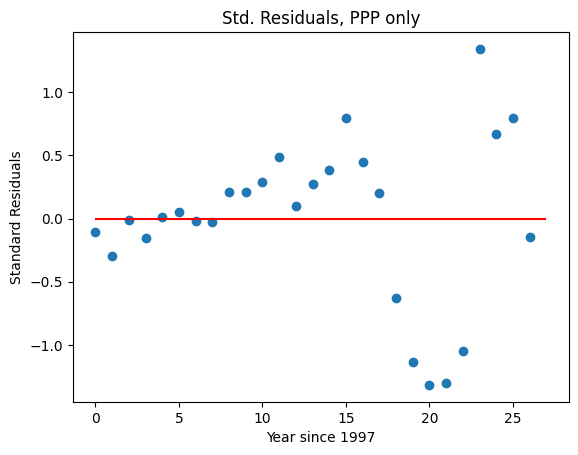

In [51]:
plt.scatter(np.arange(len(y)), betareg.std_resids(paramsp, Xp, yp))
plt.xlabel("Year since 1997")
plt.ylabel("Standard Residuals")
plt.hlines(0, 0, 27, color="red")
plt.title("Std. Residuals, PPP only")
# plt.savefig("images/pppstd")

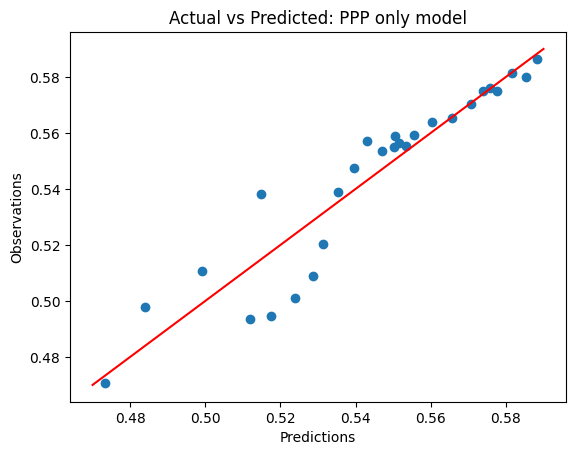

In [52]:
plt.title("Actual vs Predicted: PPP only model")
plt.xlabel("Predictions")
plt.ylabel("Observations")
plt.scatter(betareg.get_mu(Xp, paramsp[:-1]), y)
plt.plot([0.47, 0.59], [0.47, 0.59], color="red")
# plt.savefig("images/pppact")

In [53]:
Xa = np.hstack([Xp[:, -1][:, None], Xh[:, -1][:, None]])
paramsa, Xa, ya, Ia = betareg.fit_regression(Xa, y)

-12.031495888715575
[ 1.74139708e-01 -1.12075048e-01  6.73026594e-03  5.51181545e+01] 47.7154175124453
[ 1.74919444e-01 -1.12649529e-01  6.73191206e-03  7.53410643e+01] 51.83440187626013
[ 1.75330935e-01 -1.12886531e-01  6.74782284e-03  9.10230122e+01] 54.299257589267086
[ 1.75665234e-01 -1.13161332e-01  6.78633277e-03  1.04269404e+02] 56.055684339354
[ 1.75831808e-01 -1.13238170e-01  6.77071636e-03  1.15934271e+02] 57.417048018258356
[ 1.75936696e-01 -1.13344564e-01  6.80192259e-03  1.26465255e+02] 58.526349627556556
[ 1.76066438e-01 -1.13421242e-01  6.76618508e-03  1.36131856e+02] 59.46090137177998
[ 1.76124384e-01 -1.13453835e-01  6.75777808e-03  1.45111144e+02] 60.26722014616098
[ 1.76200870e-01 -1.13504676e-01  6.76814022e-03  1.53526956e+02] 60.97548452793535
[ 1.76247897e-01 -1.13553150e-01  6.79242815e-03  1.61469849e+02] 61.60636595912047
[ 1.76313540e-01 -1.13562783e-01  6.76997161e-03  1.69008459e+02] 62.17464931090444
[ 1.76330882e-01 -1.13599600e-01  6.79009050e-03  1.7619

In [54]:
betareg.summary(paramsa, ["GDP (PPP) Per capita", "Avg People Per Household"], Xa, ya, Ia)

Beta Regression Summary
Coefficient                Value   Wald    P-value 
Intercept                  0.18    13.07   0.00    
GDP (PPP) Per capita       -0.11   -3.59   0.00    
Avg People Per Household   0.01    0.21    0.83    

Log-Likelihood:   79.20


In [55]:
betareg.lr_test(paramsa, paramsp, Xa, Xp, y)

LR Test: 1 parameter difference:
X2 Stat: 0.0711864892327867
P-Value: 0.7896170226963062


### Interaction effects & regularization

In [132]:
importlib.reload(betareg)

<module 'betareg' from 'c:\\Users\\yuhha\\OneDrive\\桌面\\LogisticProject-main\\LogisticProject-main\\betareg.py'>

In [133]:
y = merged_df['Food_At_Home_Proportion'].values
y = np.clip(y, 1e-12, 1 - 1e-12)
ppp_standardized = (ppp - np.mean(ppp)) / np.std(ppp)
houseSize_standardized = (houseSize[:-1] - np.mean(houseSize[:-1])) / np.std(houseSize[:-1])
away_sales = merged_df['Total_Food_Away_Sales_Nominal'].values
dpi_share = merged_df['Food_At_Home_DPI_Share'].values
away_sales_standardized = (away_sales - np.mean(away_sales)) / np.std(away_sales)
dpi_share_standardized = (dpi_share - np.mean(dpi_share)) / np.std(dpi_share)


X = np.column_stack([
    ppp_standardized,
    houseSize_standardized,
    away_sales_standardized,
    dpi_share_standardized
])

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 27 and the array at index 1 has size 26

In [ ]:
lambda_ridge = 0.01

params_ridge, X_ridge, y_ridge, I_ridge = betareg.fit_regression_ridge(X, y, lambda_ridge=lambda_ridge)

342.11137679364003
[ 6.63259343e+00 -1.35154203e-14  8.71936204e-15 -6.35680816e-15
  7.75732598e-15  3.23201398e+01] 633.2116412739205
[ 6.71182218e+00 -3.67922321e-15 -1.04199718e-15  2.97063985e-15
 -1.36273006e-15  3.52205882e+01] 633.3002316322948
[ 6.78218803e+00 -3.12683937e-15  1.44987575e-15  4.60967712e-15
  9.50667659e-16  3.78655828e+01] 633.3752161064555
[ 6.84496226e+00 -4.52787431e-15  3.63190327e-16  2.52206489e-15
 -7.84958309e-16  4.03960020e+01] 633.4422446293128
[ 6.90150841e+00 -3.40171342e-15 -5.74853348e-17  2.96491222e-15
 -2.30389982e-17  4.28228385e+01] 633.502738696852


In [ ]:
print("Beta Regression Summary with Ridge Regularization")
print(f"Note: Ridge regularization applied (lambda = {lambda_ridge}). Test statistics and likelihood are not reported.")
names = [
    "Intercept",
    "Per capita GDP (PPP) (standardized)",
    "Average number of people per household (standardized)",
    "Nominal away-from-home food sales (standardized)",
    "Share of DPI allocated to at-home food (standardized)"
]
w1 = max([len(name) + 3 for name in names] + [len("Coefficient") + 3])
print(f"{'Coefficient':<{w1}}{'Value':<8}")
for i, name in enumerate(names):
    print(f"{name:<{w1}}{params_ridge[i]:<8.6f}")

Beta Regression Summary with Ridge Regularization
Note: Ridge regularization applied (lambda = 0.01). Test statistics and likelihood are not reported.
Coefficient                                             Value   
Intercept                                               6.901508
Per capita GDP (PPP) (standardized)                     -0.000000
Average number of people per household (standardized)   -0.000000
Nominal away-from-home food sales (standardized)        0.000000
Share of DPI allocated to at-home food (standardized)   -0.000000


Bad.

# Using monthly data

In [ ]:
monthly_df = pd.read_csv('monthly_sales by outlet.csv')

numerical_cols_monthly = [col for col in monthly_df.columns if col not in ['Year', 'Month']]
for col in numerical_cols_monthly:
    if monthly_df[col].dtype == 'object':
        monthly_df[col] = pd.to_numeric(monthly_df[col].str.replace(',', ''), errors='coerce')

monthly_df['Food_At_Home_Proportion'] = (
    monthly_df['Total food at home sales million nominal U.S. dollars with taxes and tips'] /
    monthly_df['Total nominal U.S. dollars food sales with taxes and tips']
)

# Merge with yearly ppp and houseSize
ppp_yearly = pd.DataFrame({
    'Year': range(1997, 2024),
    'Per capita GDP (PPP)': ppp
})
houseSize_yearly = pd.DataFrame({
    'Year': range(1997, 2024),
    'Average number of people per household': houseSize
})

monthly_df = monthly_df.merge(ppp_yearly, on='Year', how='left')
monthly_df = monthly_df.merge(houseSize_yearly, on='Year', how='left')

predictors = [
    'Per capita GDP (PPP)',
    'Average number of people per household',
    'Total food away from home sales million nominal U.S. dollars with taxes and tips',
    'Full-service restaurants sales million nominal U.S. dollars with taxes and tips',
    'Limited-service restaurants sales million nominal U.S. dollars with taxes and tips'
]

X_monthly = monthly_df[predictors].values
X_monthly = (X_monthly - np.mean(X_monthly, axis=0)) / np.std(X_monthly, axis=0)
y_monthly = monthly_df['Food_At_Home_Proportion'].values
y_monthly = np.clip(y_monthly, 1e-12, 1 - 1e-12)

In [121]:
# Add Month as a categorical variable and fit the model
monthly_df['Month'] = pd.Categorical(monthly_df['Month'], categories=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
month_dummies = pd.get_dummies(monthly_df['Month'], prefix='Month').values
X_monthly_with_month = np.hstack([X_monthly, month_dummies])

# Add COVID-19 indicator (2020–2021)
monthly_df['COVID_Period'] = ((monthly_df['Year'] >= 2020) & (monthly_df['Year'] <= 2021)).astype(int)
X_monthly_with_month_covid = np.hstack([X_monthly_with_month, monthly_df['COVID_Period'].values.reshape(-1, 1)])

# Fit the model with increased lambda_ridge
lambda_ridge = 0.1  # Increased to encourage more spread in predictions
params_monthly, X_ridge_monthly, y_ridge_monthly, I_ridge_monthly = betareg.fit_regression(
    X_monthly_with_month_covid, y_monthly, lambda_ridge=lambda_ridge
)

# Display coefficients
names = ["Intercept", "Per capita GDP (PPP) (standardized)", "Average number of people per household (standardized)",
         "Nominal away-from-home food sales (standardized)", "Full-service restaurants sales (standardized)",
         "Limited-service restaurants sales (standardized)"] + [f"Month_{m}" for m in [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]] + ["COVID_Period"]
w1 = max([len(name) + 3 for name in names] + [len("Coefficient") + 3])
print(f"{'Coefficient':<{w1}}{'Value':<8}")
for i, name in enumerate(names):
    print(f"{name:<{w1}}{params_monthly[i]:<8.2f}")

# Cross-validation with updated predictors
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores_monthly = []
all_y_true = []
all_y_pred = []
dates = []

for train_index, test_index in kf.split(X_monthly_with_month_covid):
    X_train, X_test = X_monthly_with_month_covid[train_index], X_monthly_with_month_covid[test_index]
    y_train, y_test = y_monthly[train_index], y_monthly[test_index]
    params, _, _, _ = betareg.fit_regression(X_train, y_train, lambda_ridge=lambda_ridge)
    X_test_with_intercept = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    mu_pred = 1 / (1 + np.exp(-np.dot(X_test_with_intercept, params[:-1])))
    mse = np.mean((y_test - mu_pred) ** 2)
    mse_scores_monthly.append(mse)
    all_y_true.extend(y_test)
    all_y_pred.extend(mu_pred)
    dates.extend(monthly_df.iloc[test_index][['Year', 'Month']].apply(lambda x: f"{x['Year']}-{x['Month']}", axis=1))

-145.10226454657737
[ 7.73253881e-02  5.70364574e-02  1.81910721e-02 -9.22307921e-02
 -1.02440417e-01  1.15896483e-02  1.08152205e-02 -3.52333002e-02
 -8.76695283e-04 -1.63402944e-02  5.91594865e-03 -1.69354803e-02
 -8.45368679e-03 -9.01374251e-03 -1.84145016e-02 -1.15860350e-03
  4.84247754e-02  1.18595748e-01  3.97895268e-02  2.79887959e+02] 821.9737280310849
[ 7.86887392e-02  8.99861678e-02  2.57678014e-02 -1.29336364e-01
 -1.14319793e-01  3.84599502e-02  5.95796005e-03 -4.08628448e-02
 -1.76026682e-04 -1.94702102e-02  7.90931882e-03 -1.67316743e-02
 -6.86130498e-03 -6.68930387e-03 -1.97425258e-02  2.37604780e-04
  4.78316578e-02  1.27286088e-01  2.07416363e-02  3.27210662e+02] 846.8416066629529
[ 7.94877889e-02  1.04304586e-01  2.95348621e-02 -1.60044605e-01
 -1.14292952e-01  5.89328887e-02  4.00907948e-03 -4.25499283e-02
 -7.76509366e-08 -2.06108229e-02  8.57958035e-03 -1.64996559e-02
 -6.29049701e-03 -5.66956716e-03 -1.97190062e-02  1.02916613e-03
  4.73724737e-02  1.29837044e-01

In [137]:
coeff_magnitudes = np.abs(params_monthly[1:6])  # First 5 predictors (excluding intercept)
var_importance = pd.DataFrame({
    'Variable': names[1:6],
    'Coefficient Magnitude': coeff_magnitudes
}).sort_values(by='Coefficient Magnitude', ascending=False)
print("Variable Importance (based on coefficient magnitudes):")
print(var_importance)

Variable Importance (based on coefficient magnitudes):
                                            Variable  Coefficient Magnitude
2   Nominal away-from-home food sales (standardized)               0.433589
4   Limited-service restaurants sales (standardized)               0.255535
0                Per capita GDP (PPP) (standardized)               0.078629
1  Average number of people per household (standa...               0.021867
3      Full-service restaurants sales (standardized)               0.013112


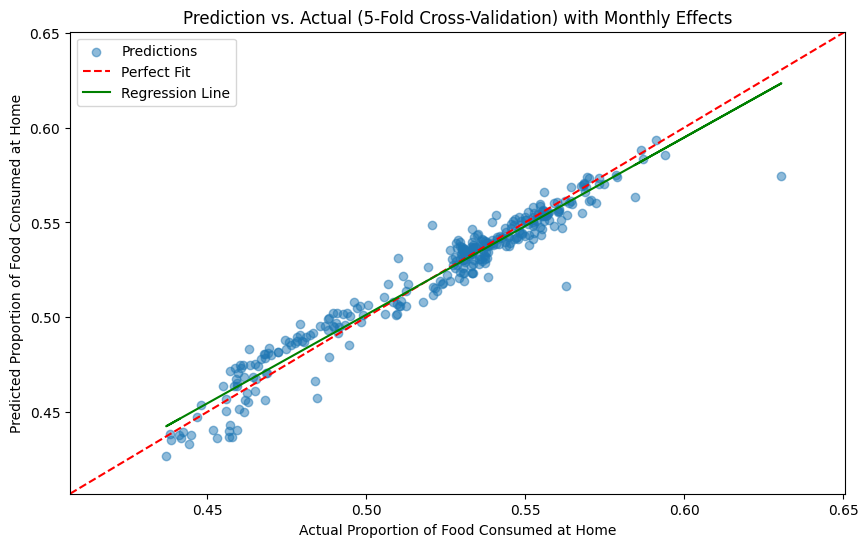

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(all_y_true, all_y_pred, alpha=0.5, label='Predictions')

min_val = min(min(all_y_true), min(all_y_pred)) - 0.02
max_val = max(max(all_y_true), max(all_y_pred)) + 0.02

plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')


z = np.polyfit(all_y_true, all_y_pred, 1)
p = np.poly1d(z)
plt.plot(np.array(all_y_true), p(np.array(all_y_true)), 'g-', label='Regression Line')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.xlabel('Actual Proportion of Food Consumed at Home')
plt.ylabel('Predicted Proportion of Food Consumed at Home')
plt.title('Prediction vs. Actual (5-Fold Cross-Validation) with Monthly Effects')
plt.legend()
# plt.savefig('Logistic Regression/Project/images/pred_vs_actual_monthly_updated.png', bbox_inches='tight')
plt.show()


In [ ]:
# Report cross-validated MSE
mean_mse_monthly = np.mean(mse_scores_monthly)
std_mse_monthly = np.std(mse_scores_monthly)
print("Cross-Validated Mean Squared Error (5-Fold) for Monthly Data with Monthly Effects:")
print(f"Mean MSE: {mean_mse_monthly}")
print(f"Std MSE: {std_mse_monthly}")


Cross-Validated Mean Squared Error (5-Fold) for Monthly Data with Monthly Effects:
Mean MSE: 7.506661887311679e-05
Std MSE: 1.1931166139834744e-05


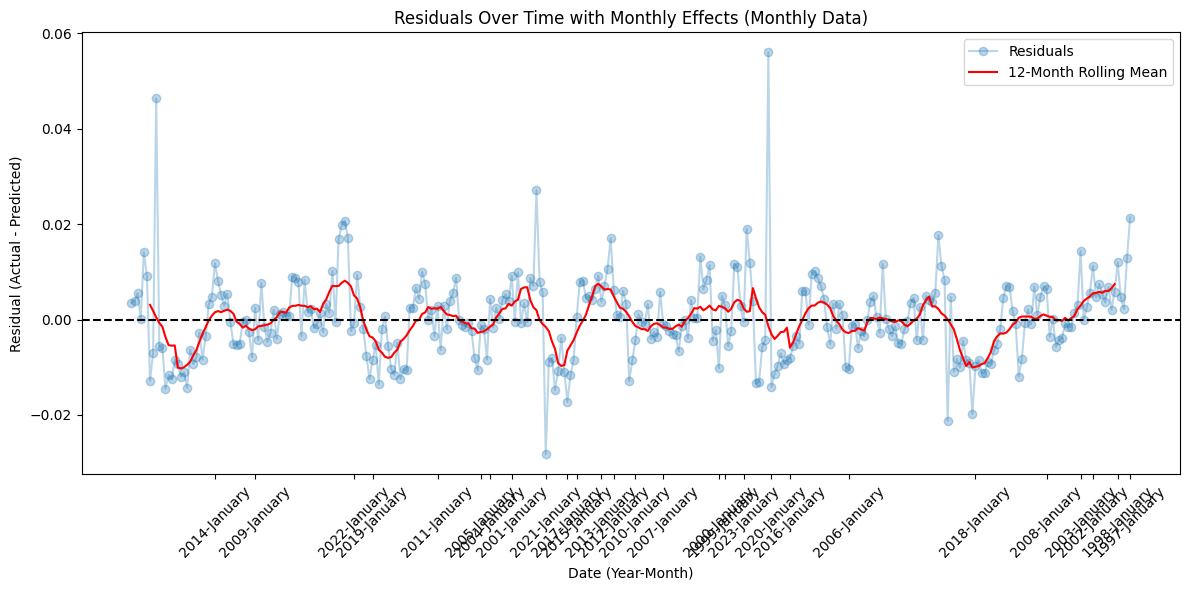

In [129]:

# Updated Residuals Over Time Plot with Rolling Mean
plt.figure(figsize=(12, 6))
residuals = np.array(all_y_true) - np.array(all_y_pred)
plt.plot(dates, residuals, 'o-', alpha=0.3, label='Residuals')
# Add rolling mean
residuals_series = pd.Series(residuals, index=dates)
rolling_mean = residuals_series.rolling(window=12, center=True).mean()
plt.plot(dates, rolling_mean, 'r-', label='12-Month Rolling Mean')
plt.axhline(0, color='black', linestyle='--')
tick_indices = [i for i, date in enumerate(dates) if 'January' in date]
tick_labels = [dates[i] for i in tick_indices]
plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
plt.xlabel('Date (Year-Month)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time with Monthly Effects (Monthly Data)')
plt.legend()
plt.tight_layout()
plt.show()